# Stage 1: Setup and Image Loading

In [38]:
%pip install -r requirements.txt
from dotenv import load_dotenv
import os
load_dotenv()
original_1_image_path = os.getenv('img_path') #r"C:/Users/joshi/OneDrive/MainFolder_Darshan_Joshi/Angelo_State_University_ASU/2025 Spring Semester 2/CS-6322-Image-Processing-Spring-2025/CS-6322-Term-Project/CS-6322-IMG-2-Runner.jpg"
background_path = os.getenv('bg_path') #r"C:/Users/joshi/OneDrive/MainFolder_Darshan_Joshi/Angelo_State_University_ASU/2025 Spring Semester 2/CS-6322-Image-Processing-Spring-2025/CS-6322-Term-Project/BG_Replace.jpg"


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


2025-05-10 01:50:56,363 - INFO - Loaded image from: ./images/test1.jpg


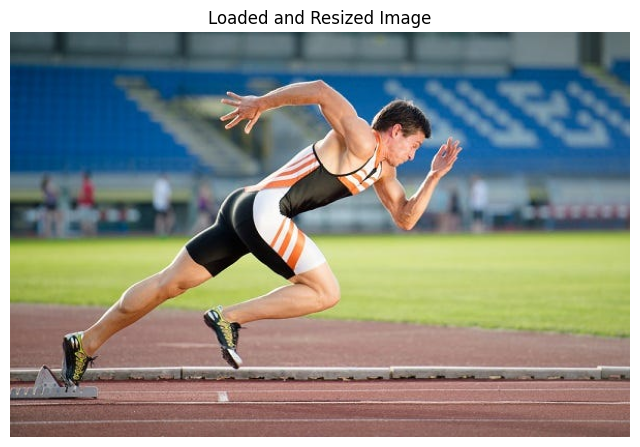

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
# from tkinter import filedialog, Tk

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_image_from_path(file_path, max_dim=800):
    """
    Loads and resizes an image from a given file path.

    Args:
        file_path (str): Path to the image
        max_dim (int): Max dimension (width or height) to resize to.

    Returns:
        tuple: (str path, np.ndarray image or None if error)
    """
    try:
        image = cv2.imread(file_path)
        if image is None:
            raise FileNotFoundError("Could not load image.")
        logging.info(f"Loaded image from: {file_path}")

        h, w = image.shape[:2]
        scale = max_dim / max(h, w)
        if scale < 1:
            image = cv2.resize(image, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)
            logging.info(f"Resized image to: {image.shape[1]}x{image.shape[0]}")
        return file_path, image

    except Exception as e:
        logging.error(f"Failed to load image: {e}")
        return None, None


def show_image(image, title="Image", is_bgr=True, size=(8, 6)):
    """
    Displays an image using matplotlib with optional BGR to RGB conversion.
    
    Args:
        image (np.ndarray): Image to show
        title (str): Window title
        is_bgr (bool): Convert BGR to RGB
        size (tuple): Matplotlib figure size
    """
    try:
        plt.figure(figsize=size)
        if is_bgr:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(title)
        plt.axis("off")
        plt.show()
    except Exception as e:
        logging.error(f"Error displaying image: {e}")




# Run this cell to test the image loader and displayer:
image_path, image = load_image_from_path(original_1_image_path)

if image is not None:
    show_image(image, title="Loaded and Resized Image")
else:
    print("No image loaded.")


# Stage 2A: Thresholding for High-Contrast Images

This method works well if:

The background is very bright or very dark compared to the subject

The subject has clearly defined edges

### Thresholding Likely Won’t Work Well because Thresholding assumes:

The background is uniform or high-contrast

The subject and background can be separated by brightness alone

Your image has:

Multiple background elements (dirt, shrubs, city, mountains)

Gradients and depth of field (blurry background)

Likely similar brightness between clothes/road and surroundings

So this method may produce a broken mask, especially around the edges and small details like arms or hair.

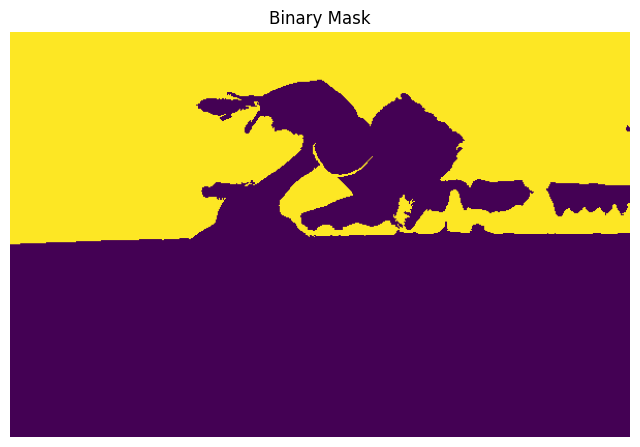

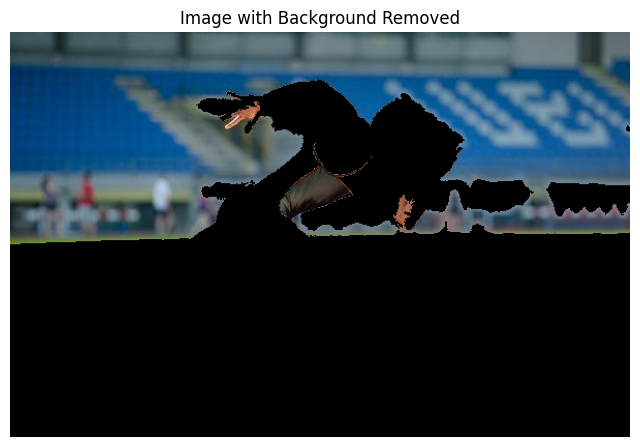

In [40]:
def create_mask_by_thresholding(image, threshold_value=127):
    """
    Performs basic background removal using grayscale thresholding.

    Args:
        image (np.ndarray): Input BGR image
        threshold_value (int): Threshold value to separate background

    Returns:
        tuple: (mask, result) where mask is binary mask and result is masked image
    """
    try:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Apply binary thresholding
        _, thresh = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Find all external contours
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if not contours:
            raise ValueError("No contours found")

        # Get the largest contour
        main_contour = max(contours, key=cv2.contourArea)

        # Create an empty mask
        mask = np.zeros_like(gray)

        # Draw filled contour on mask
        cv2.drawContours(mask, [main_contour], -1, 255, thickness=cv2.FILLED)

        # Apply the mask to the original image
        result = cv2.bitwise_and(image, image, mask=mask)

        return mask, result

    except Exception as e:
        logging.error(f"Thresholding mask generation failed: {e}")
        return None, None

# Run this after loading the image
mask, result = create_mask_by_thresholding(image)

if mask is not None:
    show_image(mask, title="Binary Mask", is_bgr=False)
    show_image(result, title="Image with Background Removed")
else:
    print("Thresholding failed.")



In [41]:
def get_user_drawn_rect(image):
    """
    Opens an OpenCV window allowing the user to draw a bounding box.

    Args:
        image (np.ndarray): The input image

    Returns:
        tuple: (x, y, w, h) bounding box
    """
    clone = image.copy()
    rect = []
    drawing = False
    ix, iy = -1, -1

    def draw_rectangle(event, x, y, flags, param):
        nonlocal ix, iy, drawing, rect, clone

        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            ix, iy = x, y

        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            temp = clone.copy()
            cv2.rectangle(temp, (ix, iy), (x, y), (0, 255, 0), 2)
            cv2.imshow("Draw bounding box (Press ENTER to confirm)", temp)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False
            rect = [min(ix, x), min(iy, y), abs(x - ix), abs(y - iy)]
            cv2.rectangle(clone, (rect[0], rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (0, 255, 0), 2)
            cv2.imshow("Draw bounding box (Press ENTER to confirm)", clone)

    # Open window and set callback
    cv2.namedWindow("Draw bounding box (Press ENTER to confirm)")
    cv2.setMouseCallback("Draw bounding box (Press ENTER to confirm)", draw_rectangle)
    cv2.imshow("Draw bounding box (Press ENTER to confirm)", image)

    print("Instructions:")
    print("1. Click and drag to draw a bounding box.")
    print("2. Press ENTER or SPACE to confirm.")
    print("3. Press ESC to cancel.")

    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 13 or key == 32:  # ENTER or SPACE
            break
        elif key == 27:  # ESC
            rect = []
            break

    cv2.destroyAllWindows()

    if len(rect) == 4:
        logging.info(f"User-drawn rectangle: {rect}")
        return tuple(rect)
    else:
        logging.warning("Bounding box selection cancelled.")
        return None

user_drawn_rectangle = get_user_drawn_rect(image) # 2025-05-06 20:44:26,242 - INFO - User-drawn rectangle: [363, 82, 286, 401]


Instructions:
1. Click and drag to draw a bounding box.
2. Press ENTER or SPACE to confirm.
3. Press ESC to cancel.


2025-05-10 01:51:03,573 - INFO - User-drawn rectangle: [16, 18, 509, 361]


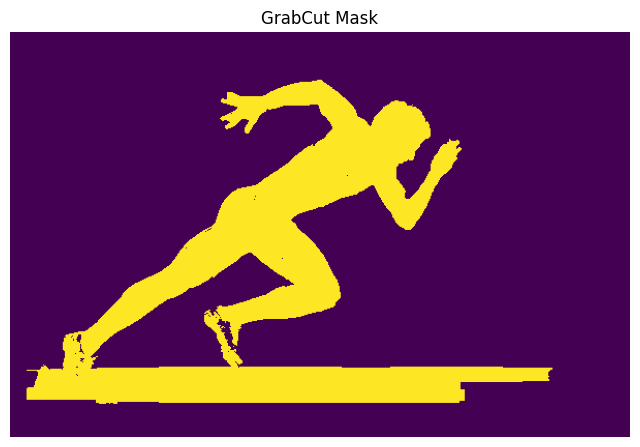

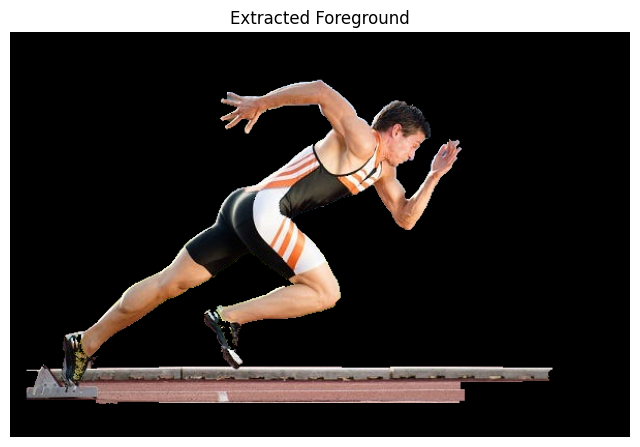

In [42]:
def apply_grabcut(image, rect=None, iter_count=5):
    """
    Applies the GrabCut algorithm to extract the foreground.

    Args:
        image (np.ndarray): Input image (BGR)
        rect (tuple): Bounding box in the format (x, y, w, h)
        iter_count (int): Number of GrabCut iterations

    Returns:
        tuple: (mask, foreground result)
    """
    try:
        mask = np.zeros(image.shape[:2], dtype=np.uint8)  # 0=bg, 1=fg, 2=prob.bg, 3=prob.g
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)

        if rect is None:
            raise ValueError("Bounding box (rect) is required for GrabCut.")

        # Apply GrabCut with rectangle
        cv2.grabCut(image, mask, rect, bgdModel, fgdModel, iterCount=iter_count, mode=cv2.GC_INIT_WITH_RECT)

        # Convert mask to binary: 0 and 2 are background, 1 and 3 are foreground
        output_mask = np.where((mask == 2) | (mask == 0), 0, 1).astype("uint8")
        foreground = image * output_mask[:, :, np.newaxis]

        return output_mask * 255, foreground, mask

    except Exception as e:
        logging.error(f"GrabCut failed: {e}")
        return None, None

# Apply GrabCut if user_drawn_rectangle is valid:
if user_drawn_rectangle:
    mask, foreground, mask_init = apply_grabcut(image, user_drawn_rectangle)
    if mask is not None:
        show_image(mask, title="GrabCut Mask", is_bgr=False)
        show_image(foreground, title="Extracted Foreground")
    else:
        print("GrabCut failed.")
else:
    print("Bounding box not selected.")


Apply manual mask

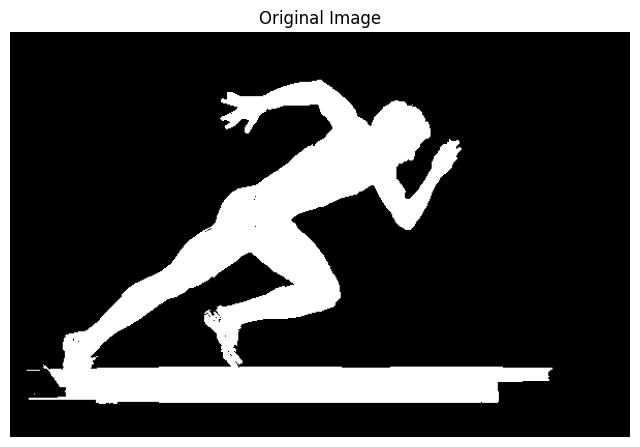

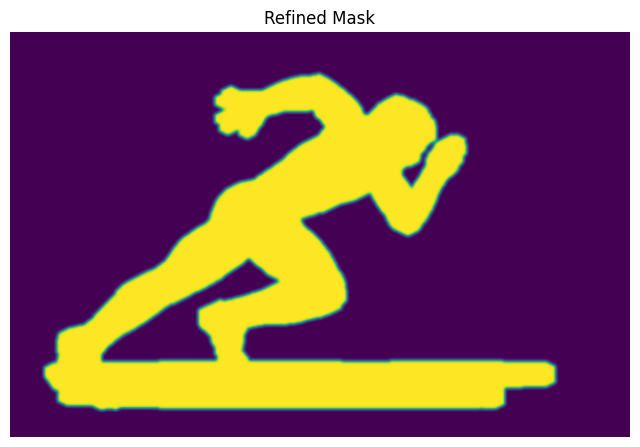

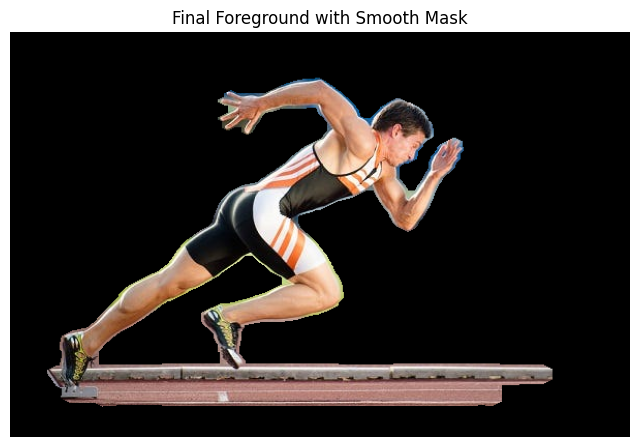

Final result shape: (392, 600, 3)


In [43]:
def refine_mask(mask, kernel_size=7, blur_size=7, iterations=7):
    """
    Cleans and smooths a binary mask.

    Args:
        mask (np.ndarray): Binary mask (0 or 255)
        kernel_size (int): Size of morphological kernel
        blur_size (int): Size of Gaussian blur kernel
        iterations (int): Dilation iterations

    Returns:
        np.ndarray: Refined mask
    """
    try:
        # Convert to 0/1 mask if needed
        binary_mask = (mask > 0).astype(np.uint8)

        # Morph kernel
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

        # Fill small holes and remove noise
        closed = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
        opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=1)

        # Optional dilation to recover lost details (e.g. fingers, wires)
        dilated = cv2.dilate(opened, kernel, iterations=iterations)

        # Feather the edges
        blurred = cv2.GaussianBlur(dilated.astype(np.float32), (blur_size, blur_size), 0)
        mask2 = np.zeros_like(blurred)

        # Scale to [0, 255] and return
        refined = (blurred * 255).astype(np.uint8)
        return refined

    except Exception as e:
        logging.error(f"Mask refinement failed: {e}")
        return mask


# Run GrabCut:
final_result = None
raw_mask = None
cutout = None
if user_drawn_rectangle:
    raw_mask, cutout, mask_init = apply_grabcut(image, user_drawn_rectangle)

    # Refine the mask
    refined_mask = refine_mask(raw_mask, kernel_size=5, blur_size=7, iterations=3)

    # Apply refined mask
    final_result = cv2.bitwise_and(image, image, mask=(refined_mask // 255))
    
    # Show results
    show_image(raw_mask, title="Original Image")
    show_image(refined_mask, title="Refined Mask", is_bgr=False)
    show_image(final_result, title="Final Foreground with Smooth Mask")
print("Final result shape:", final_result.shape)

Instructions:
1. Click and drag to draw a bounding box.
2. Press ENTER or SPACE to confirm.
3. Press ESC to cancel.
User-drawn mask shape: (392, 600)
raw_mask shape: (392, 600)


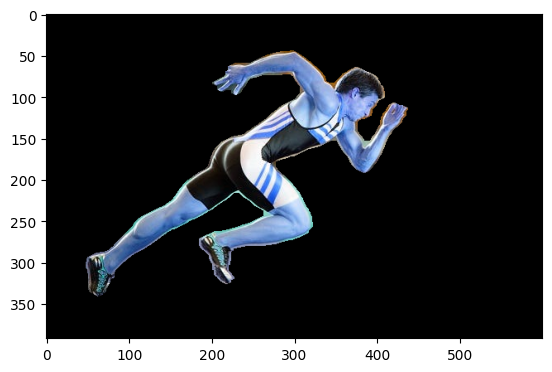

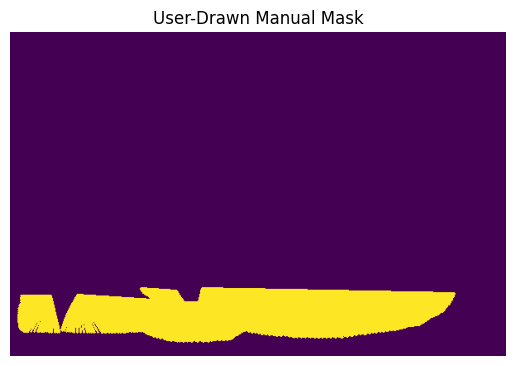

In [44]:
def get_user_manual_mask(image):
    """
    Opens an OpenCV window allowing the user to draw a bounding box.

    Args:
        image (np.ndarray): The input image

    Returns:
        np.ndarray: Binary mask
    """
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clone = image.copy()
        
    drawing = False
    ix, iy = -1, -1
    val = 255
    mask = np.zeros_like(gray, dtype=np.uint8)
    print("Instructions:")
    print("1. Click and drag to draw a bounding box.")
    print("2. Press ENTER or SPACE to confirm.")
    print("3. Press ESC to cancel.")

    def draw_manual_mask(event, x, y, flags, param):
        nonlocal ix, iy, drawing, mask, clone, val
    
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            val = 255
            ix, iy = x, y
        elif event == cv2.EVENT_RBUTTONDOWN:
            drawing = True
            val = 0
            ix, iy = x, y

        elif event == cv2.EVENT_MOUSEMOVE and drawing:
            temp = clone.copy()            
            cv2.line(mask, (ix, iy), (x, y), val, 2)
            cv2.line(clone, (ix, iy), (x, y), (0, val, 0), 2)
            cv2.imshow("Draw Manual mask (Press ENTER to confirm)", temp)

        elif event == cv2.EVENT_LBUTTONUP:
            drawing = False 

    # Open window and set callback
    cv2.namedWindow("Draw Manual mask (Press ENTER to confirm)")
    cv2.setMouseCallback("Draw Manual mask (Press ENTER to confirm)", draw_manual_mask)
    cv2.imshow("Draw Manual mask (Press ENTER to confirm)", image) 

    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 13 or key == 32:  # ENTER or SPACE
            break
        elif key == 27:  # ESC
            mask = []
            break
            
    cv2.destroyAllWindows()

    return mask
user_drawn_mask = get_user_manual_mask(final_result)
print("User-drawn mask shape:", user_drawn_mask.shape)
print("raw_mask shape:", raw_mask.shape)
# Apply GrabCut with user-drawn mask
#raw_mask = np.zeros(image.shape[:2], dtype=np.uint8)

mask_init[user_drawn_mask == 255] = 0

bgdModel = np.zeros((1,65), dtype=np.float64)
fgdModel = np.zeros((1,65), dtype=np.float64)
mask, bgdModel, fgdModel = cv2.grabCut(image,mask_init,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
mask2 = mask2 * 255
refined_mask = refine_mask(mask2, kernel_size=5, blur_size=7, iterations=3)

    # Apply refined mask
final_result = cv2.bitwise_and(image, image, mask=(refined_mask // 255))
plt.imshow(final_result)
plt.show()


plt.imshow(user_drawn_mask)
plt.title("User-Drawn Manual Mask")
plt.axis("off")
plt.show()


In [45]:
def apply_transparency(image, mask):
    """
    Applies mask to image and returns a 4-channel BGRA image (transparent background).

    Args:
        image (np.ndarray): Input BGR image
        mask (np.ndarray): Refined mask, values in [0, 255]

    Returns:
        np.ndarray: Image with alpha channel (BGRA)
    """
    try:
        b, g, r = cv2.split(image)
        alpha = mask  # Use mask as alpha channel
        transparent = cv2.merge([b, g, r, alpha])
        return transparent
    except Exception as e:
        logging.error(f"Failed to apply transparency: {e}")
        return None

transparent_result = apply_transparency(image, refined_mask)
if transparent_result is not None:
    cv2.imwrite("runner_transparent.png", transparent_result)
    logging.info("Saved runner_transparent.png with transparent background.")


2025-05-10 01:51:32,032 - INFO - Saved runner_transparent.png with transparent background.


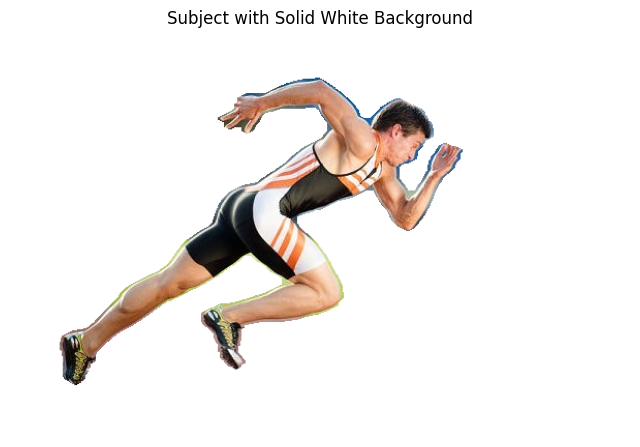

In [46]:
def replace_with_solid_color(image, mask, color=(255, 255, 255)):
    """
    Replaces the background of the image with a solid BGR color.

    Args:
        image (np.ndarray): Input image
        mask (np.ndarray): Refined mask (0-255)
        color (tuple): BGR color tuple (e.g., white=(255,255,255))

    Returns:
        np.ndarray: Image with solid background
    """
    try:
        background = np.full_like(image, color, dtype=np.uint8)
        mask_3ch = cv2.merge([mask // 255] * 3)  # Convert to 3-channel binary mask
        result = (image * mask_3ch) + (background * (1 - mask_3ch))
        return result
    except Exception as e:
        logging.error(f"Solid color replacement failed: {e}")
        return None

solid_result = replace_with_solid_color(image, refined_mask, color=(255, 255, 255))  # white bg
show_image(solid_result, title="Subject with Solid White Background")


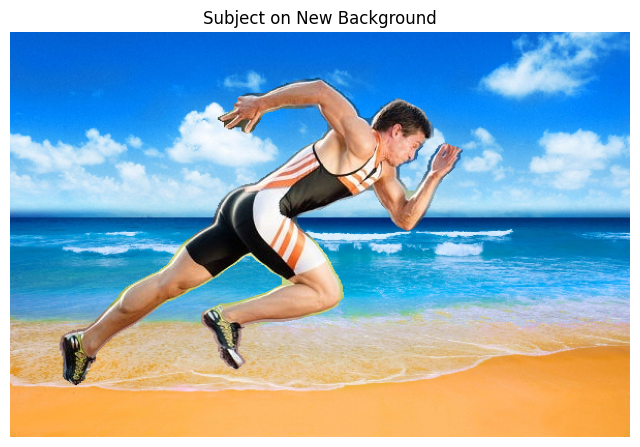

In [47]:


def replace_background_with_image(image, mask, background_image):
    """
    Replaces background of the subject with a new image.

    Args:
        image (np.ndarray): Original image (BGR)
        mask (np.ndarray): Refined mask (0-255)
        background_image (np.ndarray): New background (must match dimensions)

    Returns:
        np.ndarray: Composite image
    """
    try:
        # Resize background to match input
        background_resized = cv2.resize(background_image, (image.shape[1], image.shape[0]))
        mask_3ch = cv2.merge([mask // 255] * 3)

        # Composite
        result = (image * mask_3ch) + (background_resized * (1 - mask_3ch))
        return result
    except Exception as e:
        logging.error(f"Background replacement failed: {e}")
        return None

# Load a replacement background

background = cv2.imread(background_path)

if background is not None:
    replaced = replace_background_with_image(image, refined_mask, background)
    show_image(replaced, title="Subject on New Background")
else:
    print("Failed to load background image.")
